In [1]:
#meta 2/16/2021 Clean Cassava 0-Data, 1-Prep Data, 2-Model
#my Cassava learning summary
#input: kaggle Cassava image files and train dataset
#output: K-Fold exports of models in .pkl format
#based on my work + concise code example by noelmat

#history
#here 02/17/2021 CLEAN CASSAVA CODE 1-Prep Data, 2-Model
#     Successfully runs in Kaggle kernel, CPU only, no GPU acceleration
#     MINI_FLG=1, proved with 1% of data that data prep and modeling code finishes
#     Manual step: create a temp folder with mini set of images
#     $param - to set MINI vs FULL params


# Cassava Leaf Disease Classification
Identify the type of disease present on a Cassava Leaf image

In [2]:
#------ global constants, vars and functions ------
SEED = 24
MINI_FLG = 1 #$mydelta $mini
MINI_DS_SIZE = 0.01 #$mydelta $mini
BS_SIZE = 32 #$mydelta from 64
N_EPOCHS = 10 #$mydelta $mini
N_FREEZE_EPOCHS = 10 #$mydelta $mini
K_FOLDS=5
MODEL = 'Res18' #$mydelta $mini

def free_gpu_cache():
    torch.cuda.empty_cache()

In [3]:
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#stratified split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold

#modeling
from fastai.vision.all import *


## 0. Load Data
21397 train images and 1 test image

- input: images
- output: labels
- train dataset maps images to labels


In [4]:
path = Path('/kaggle/input/cassava-leaf-disease-classification/')
path.ls()

(#7) [Path('/kaggle/input/cassava-leaf-disease-classification/train_tfrecords'),Path('/kaggle/input/cassava-leaf-disease-classification/sample_submission.csv'),Path('/kaggle/input/cassava-leaf-disease-classification/test_tfrecords'),Path('/kaggle/input/cassava-leaf-disease-classification/label_num_to_disease_map.json'),Path('/kaggle/input/cassava-leaf-disease-classification/train_images'),Path('/kaggle/input/cassava-leaf-disease-classification/train.csv'),Path('/kaggle/input/cassava-leaf-disease-classification/test_images')]

In [5]:
train_df = pd.read_csv(path/'train.csv')
print(train_df.dtypes)
train_df.head()

image_id    object
label        int64
dtype: object


,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


0     1087
1     2189
2     2386
3    13158
4     2577
Name: label, dtype: int64


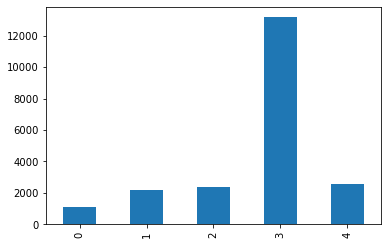

In [6]:
print(train_df['label'].value_counts().sort_index())
train_df['label'].value_counts().plot(kind='bar');

## 1. Prep Data
### 1.1 Full or Mini dataset


TRAIN: [ 4634  6429 13382 ...  7329   927  8975] VALID: [ 8524 19551  8569 13995  6510   580 15052  1705 13869 19029 19558 14644
  4858  2988 14372  9906 19321  4427 20278  3734 20062  1896 17619 12935
  4346 16572  7395 13756  7026 14845 10024 14892 15595  6656  1848  7369
  5658 20101 14431  2924  3528  2248 19041  9741 18686 16859 17196 11329
 14598 21115 10603 18114  8687 19785    51    19  4417 15326 18747 19262
 12057   690 20133  1529 16102 14673 19013 14369  9729  2743  1191  1439
 14554 11378 10461 14263  7411  8112 13996 14703  5167 11514  2809 13870
  1462  1516   109 15175  5465 13390  9858 13030 13779 13591 15311  3587
   864  5889 20849 19415  8750 15108 15050 17987 12831 14092 20011 12184
 10750  3515 20631  4874 19288  3890  3020  2947  8682 19528 19066 11748
  8365  2057  8622 11444  2704  3177 15188 17928  1683 16667 19189 21153
   989  6537 15137  4698 12721  7606 15435  4109 12929   125 18396 20232
  1774 16059 18348  8746 19720  6252 15621  8312 16240  3728 16550 1

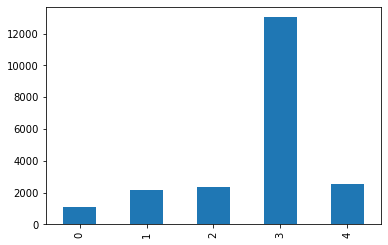

In [7]:
#train mini subsample for rapid iteration
if MINI_FLG:
    #stratified subsample
    X_mini = train_df['image_id']
    y_mini = train_df['label']
    sss_mini = StratifiedShuffleSplit(n_splits=1, test_size=MINI_DS_SIZE, random_state=SEED)
    
    for train_idx_mini, valid_idx_mini in sss_mini.split(X_mini, y_mini):
        print("TRAIN:", train_idx_mini, "VALID:", valid_idx_mini)
        y_train_mini, y_valid_mini = y_mini[train_idx_mini], y_mini[valid_idx_mini]

    y_train_mini.value_counts().sort_index()
    y_train_mini.value_counts().sort_index().plot(kind='bar');

In [8]:
#train subsample
if MINI_FLG:
    #update train_df with train index 
    train_df = train_df.loc[train_df.index.isin(valid_idx_mini)].reset_index(drop=True)
    print(train_df.shape)
    print(train_df.dtypes)
    print(train_df.head())


(214, 2)
image_id    object
label        int64
dtype: object
         image_id  label
0  1003987001.jpg      3
1  1009361983.jpg      3
2  1018973237.jpg      0
3  1022283943.jpg      3
4  1072929806.jpg      3


0     11
1     22
2     24
3    131
4     26
Name: label, dtype: int64


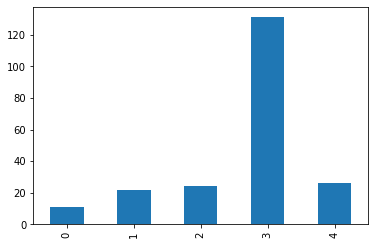

In [9]:
print(train_df['label'].value_counts().sort_index())
train_df['label'].value_counts().sort_index().plot(kind='bar');

### 1.2 K-fold Stratified Split
For cross validation, create `stratified k-folds` preserving the percentage of samples for each class.  Provides train/valid indices to split data into cv train/valid sets. 

In [10]:
#define X&y
X = train_df
y = train_df['label']


#split for cv
cv = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=SEED)
splits = {}

for i,(tr_idx,val_idx) in enumerate(cv.split(X, y)):
    splits[i] = [tr_idx, val_idx] #class list of numpy arrays
    
#preview
print("splits and shapes: ", splits.keys(), splits[0][0].shape, splits[0][1].shape)
#splits #class dict {k,v} k: fold number, v: list of 2 numpy array of indices: train/valid
#splits[0] #class a list of 2 numpy array of indices: train/valid

splits and shapes:  dict_keys([0, 1, 2, 3, 4]) (171,) (43,)


### 1.3 Data Struct
dict {image_id, label}

In [11]:
df = train_df.set_index('image_id')
print(df.head(1))

labels = df.to_dict()['label'] #class dict
len(labels)

                label
image_id             
1003987001.jpg      3


214

In [12]:
%%time
#lookup image label
labels['1003987001.jpg']

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 9.3 µs


3

In [13]:
def get_label(labels, x):
    x = Path(x)
    return labels[x.name]

In [14]:
#$acdelete 1235188286.jpg
get_label(labels,path/'train_images/1003987001.jpg')
#labels['1235188286.jpg']
#labels
df.shape

(214, 1)

In [15]:
%%time
#use fn to lookup image label - one image
get_label(labels,path/'train_images'/train_df.iloc[0,0])

CPU times: user 316 µs, sys: 0 ns, total: 316 µs
Wall time: 324 µs


3

In [16]:
def get_splits(FOLD, x):
    return splits[FOLD]

In [17]:
#manual step - create a temp folder with mini train images
if MINI_FLG:
    str_mini_images = json.dumps(list(labels.keys()))
    print(str_mini_images)
     

["1003987001.jpg", "1009361983.jpg", "1018973237.jpg", "1022283943.jpg", "1072929806.jpg", "1094294460.jpg", "1100677588.jpg", "1119593200.jpg", "1120933008.jpg", "1148267148.jpg", "1171170982.jpg", "1207471454.jpg", "1252538311.jpg", "1257722336.jpg", "1265114019.jpg", "12688038.jpg", "1269902527.jpg", "1288923505.jpg", "1293702189.jpg", "1298749911.jpg", "1311772076.jpg", "1327003472.jpg", "1329605336.jpg", "1334904382.jpg", "1359200021.jpg", "1364299181.jpg", "1390241299.jpg", "1423499316.jpg", "146995101.jpg", "1478209787.jpg", "1488108256.jpg", "1505418979.jpg", "1510384617.jpg", "151804791.jpg", "1524143324.jpg", "1547490615.jpg", "1551517348.jpg", "1620145508.jpg", "1621972953.jpg", "1634561629.jpg", "1659810136.jpg", "1660974563.jpg", "1689265715.jpg", "169189292.jpg", "1733574271.jpg", "1765348139.jpg", "1776479289.jpg", "1788823125.jpg", "1790319061.jpg", "1837622218.jpg", "1853237353.jpg", "186667196.jpg", "1869765535.jpg", "191741846.jpg", "1921186959.jpg", "1924021542.jpg"

In [19]:
#mystop
#to process this cell manually

#create temp mini train folder
if MINI_FLG:
    if not os.path.exists('/kaggle/working/mini_folder/'):
        os.makedirs('mini_folder/')

    os.chdir('../input/cassava-leaf-disease-classification/train_images')
    
    #copy mini files
    #!cp 1761091007.jpg  /kaggle/working/mini_folder
    #!cp '1003987001.jpg' '1004672608.jpg' /kaggle/working/mini_folder
    !cp "1003987001.jpg" "1009361983.jpg" "1018973237.jpg" "1022283943.jpg" "1072929806.jpg" "1094294460.jpg" "1100677588.jpg" "1119593200.jpg" "1120933008.jpg" "1148267148.jpg" "1171170982.jpg" "1207471454.jpg" "1252538311.jpg" "1257722336.jpg" "1265114019.jpg" "12688038.jpg" "1269902527.jpg" "1288923505.jpg" "1293702189.jpg" "1298749911.jpg" "1311772076.jpg" "1327003472.jpg" "1329605336.jpg" "1334904382.jpg" "1359200021.jpg" "1364299181.jpg" "1390241299.jpg" "1423499316.jpg" "146995101.jpg" "1478209787.jpg" "1488108256.jpg" "1505418979.jpg" "1510384617.jpg" "151804791.jpg" "1524143324.jpg" "1547490615.jpg" "1551517348.jpg" "1620145508.jpg" "1621972953.jpg" "1634561629.jpg" "1659810136.jpg" "1660974563.jpg" "1689265715.jpg" "169189292.jpg" "1733574271.jpg" "1765348139.jpg" "1776479289.jpg" "1788823125.jpg" "1790319061.jpg" "1837622218.jpg" "1853237353.jpg" "186667196.jpg" "1869765535.jpg" "191741846.jpg" "1921186959.jpg" "1924021542.jpg" "1972409682.jpg" "2006215409.jpg" "2021244568.jpg" "2051265559.jpg" "2097195239.jpg" "2119378021.jpg" "2166665213.jpg" "2167697247.jpg" "2173342901.jpg" "2179767086.jpg" "2189576451.jpg" "219119835.jpg" "2222998086.jpg" "2256445671.jpg" "2318255553.jpg" "2321781860.jpg" "232348694.jpg" "2353083243.jpg" "2433407680.jpg" "2438476273.jpg" "2476543961.jpg" "2485888948.jpg" "2494580860.jpg" "2512237524.jpg" "2520781924.jpg" "2530320825.jpg" "2539159693.jpg" "2540204490.jpg" "254949924.jpg" "2550003581.jpg" "2680534189.jpg" "2725353705.jpg" "2729556493.jpg" "2735085014.jpg" "2753152635.jpg" "276208116.jpg" "2782668721.jpg" "2795551857.jpg" "279831330.jpg" "2865650772.jpg" "2869232623.jpg" "2889971119.jpg" "2914451670.jpg" "296732943.jpg" "297361079.jpg" "2992877889.jpg" "3022337655.jpg" "3031606396.jpg" "3044369161.jpg" "3052425388.jpg" "3057571955.jpg" "3102075869.jpg" "3118659210.jpg" "3159203508.jpg" "318227226.jpg" "3209323639.jpg" "3277182366.jpg" "3278774878.jpg" "3298093070.jpg" "3313790300.jpg" "3315008356.jpg" "3335092693.jpg" "3347996516.jpg" "3376184680.jpg" "3395851593.jpg" "3430125708.jpg" "3440246067.jpg" "3460216646.jpg" "3464808111.jpg" "3480553170.jpg" "3480744448.jpg" "3485950795.jpg" "3501238872.jpg" "3501265654.jpg" "35180724.jpg" "3549527627.jpg" "3570668460.jpg" "3571106948.jpg" "3581888901.jpg" "3594393384.jpg" "3608399345.jpg" "3615932083.jpg" "3624585.jpg" "3626187971.jpg" "3630824057.jpg" "3636364733.jpg" "3662748819.jpg" "3672385003.jpg" "3703003342.jpg" "3703439317.jpg" "3714169299.jpg" "3719137724.jpg" "3725380699.jpg" "3728785468.jpg" "3743115520.jpg" "375108909.jpg" "3753582415.jpg" "3775506887.jpg" "3803338258.jpg" "3808126182.jpg" "3889929360.jpg" "3899862618.jpg" "3924823843.jpg" "396060343.jpg" "3961117682.jpg" "397477697.jpg" "3979130498.jpg" "3982368414.jpg" "3997023855.jpg" "4033546541.jpg" "4034095153.jpg" "4040452479.jpg" "4096966485.jpg" "4173521076.jpg" "4184062100.jpg" "4207597254.jpg" "4215244581.jpg" "422690051.jpg" "4240447884.jpg" "4261378787.jpg" "436011038.jpg" "444416814.jpg" "493875479.jpg" "503366497.jpg" "50441514.jpg" "525349447.jpg" "548412421.jpg" "551051657.jpg" "553204190.jpg" "560477016.jpg" "570097057.jpg" "585067161.jpg" "598088658.jpg" "602912992.jpg" "610094717.jpg" "625250328.jpg" "646999993.jpg" "651123589.jpg" "65235972.jpg" "682271538.jpg" "692997740.jpg" "706776365.jpg" "731031258.jpg" "739346655.jpg" "745723934.jpg" "746746526.jpg" "752382759.jpg" "773130398.jpg" "782115033.jpg" "84689733.jpg" "854773586.jpg" "878183173.jpg" "888983519.jpg" "915715866.jpg" "941512047.jpg" "942738737.jpg" "949971770.jpg" "996927503.jpg" /kaggle/working/mini_folder 

In [ ]:
mystop 
#to process above cell manually


### 1.4 From Data to Dataloaders
with DataBlock

In [20]:
if MINI_FLG:
    path_images = '/kaggle/working/mini_folder/' #$mydelta $mini
else:
    path_images = path/'train_images'

#wrap dataloaders code into a function
def get_data(labels,split,bs=BS_SIZE, presize=500, resize=384): #$mydelta $param
    tfms = [Rotate(90), Warp(magnitude=0.4, p=1.),Zoom(min_zoom=0.9, max_zoom=1.3), Brightness(max_lighting=0.5), Flip(), Contrast(), Resize(resize)]
    comp = setup_aug_tfms(tfms)
    return DataBlock(blocks=(ImageBlock, CategoryBlock),
        get_items=lambda p: get_image_files(p),
        get_y=partial(get_label, labels),
        splitter=partial(get_splits, split),
        item_tfms=[Resize(presize)],
        batch_tfms=[*comp, Normalize.from_stats(*imagenet_stats)]).dataloaders(path_images,bs=bs,num_workers=8)        
        #batch_tfms=[*comp, Normalize.from_stats(*imagenet_stats)]).dataloaders(path/'train_images',bs=bs,num_workers=8) #$mydelta $mini

In [25]:
#preview $todo
#dls = get_data(0,0)
#dls.train.show_batch()

## 2. Model

In [22]:
os.makedirs('/root/.cache/torch/hub/checkpoints/', exist_ok=True)

In [23]:
if MODEL == 'Res18':
    !cp /kaggle/input/fastai-pretrained/resnet18-5c106cde.pth /root/.cache/torch/hub/checkpoints/
else:
    !cp /kaggle/input/fastai-pretrained/resnet50-19c8e357.pth /root/.cache/torch/hub/checkpoints/

In [24]:
#track time
t0 = time.time()

for split in range(K_FOLDS): #$mini
    #track fold time
    t1 = time.time()

    dls = get_data(labels,split,bs=BS_SIZE)
    
    free_gpu_cache() #$mydelta
    
    learn = cnn_learner(dls, models.resnet50, metrics=[accuracy]).to_fp16() #$mydelta $param models.resnet18
    learn.freeze()
    # learn.lr_find()
    learn.fit_one_cycle(N_FREEZE_EPOCHS, 5e-3, cbs=[MixUp()]) #$mydelta $param
    #learn.save(f'resnet50-frozen-fold_{split}') #$mydelta
    learn.unfreeze()
    learn.fit_one_cycle(N_EPOCHS, slice(1e-5, 1e-4), cbs=[MixUp()]) #$mydelta $param
    #learn.save(f'resnet50-full-fold_{split}') #$mydelta
    
    #export model
    learn.export(f'/kaggle/working/model_{split}.pkl') 
    
    print ("Fold Training time (in min)", (time.time() - t1)/60)
    
print ("Total Training time (in min)", (time.time() - t0)/60)

/opt/conda/lib/python3.7/site-packages/torch/cuda/amp/autocast_mode.py:114: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")
/opt/conda/lib/python3.7/site-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


epoch,train_loss,valid_loss,accuracy,time
0,2.745063,1.894575,0.651163,01:36


epoch,train_loss,valid_loss,accuracy,time
0,2.322731,1.330660,0.604651,02:00


Fold Training time (in min) 3.6486884633700054


/opt/conda/lib/python3.7/site-packages/torch/cuda/amp/autocast_mode.py:114: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")
/opt/conda/lib/python3.7/site-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


epoch,train_loss,valid_loss,accuracy,time
0,2.675437,3.897366,0.116279,01:58


epoch,train_loss,valid_loss,accuracy,time
0,1.961990,2.342806,0.186047,02:05


Fold Training time (in min) 4.065410780906677
Total Training time (in min) 7.714137188593546


Exported models are ready for K-Fold inference